In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Flatten, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Set memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [18]:
# List of CSV files
csv_files = ['/Users/sanjay/Desktop/Dproject/UNSW-NB15_1.csv',
             '/Users/sanjay/Desktop/Dproject/UNSW-NB15_2.csv',
             '/Users/sanjay/Desktop/Dproject/UNSW-NB15_3.csv',
             '/Users/sanjay/Desktop/Dproject/UNSW-NB15_4.csv']

# Specify the data types for problematic columns
dtype_dict = {
    'srcip': str,
    'sport': str,
    'dstip': str,
    'dsport': str,
    'proto': str,
    'state': str,
    'service': str,
    'attack_cat': str
}
# Load and concatenate CSV files into a single DataFrame with progress bar
dfs = []
for file in tqdm(csv_files, desc='Loading CSV files'):
    dfs.append(pd.read_csv(file, dtype=dtype_dict, header=None, low_memory=False))

print("Concatenating dataframes")
df = pd.concat(dfs, ignore_index=True)



Loading CSV files: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Concatenating dataframes


In [19]:
# Assign column names based on your schema or list of column names
df.columns = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
              'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
              'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
              'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
              'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
              'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
              'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']

# Define categorical and numerical columns
cat_cols = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']
num_cols = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload',
            'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz',
            'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt',
            'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
            'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst',
            'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']

# Handle missing values with mode for categorical and median for numerical
for col in tqdm(cat_cols, desc='Handling missing values and encoding categorical variables'):
    if col in df.columns:  # Check if column exists in DataFrame
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
            df[col] = df[col].astype(str)  # Ensure column is string type
            df[col] = LabelEncoder().fit_transform(df[col])
        else:
            df[col].fillna(df[col].median(), inplace=True)
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Handle missing values and convert numerical columns to float
for col in tqdm(num_cols, desc='Handling missing values and converting to float'):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

# Normalize numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Ensure label column exists
if 'label' not in df.columns:
    raise ValueError("The dataset must have a 'label' column defined as the target.")



Handling missing values and encoding categorical variables:   0%|          | 0/8 [00:00<?, ?it/s]/var/folders/yy/c9v_rc4x1cx2vjqbzy7wc3f80000gn/T/ipykernel_10267/3320199289.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
Handling missing values and encoding categorical variables:  12%|█▎        | 1/8 [00:00<00:02,  2.50it/s]/var/folders/yy/c9v_rc4x1cx2vjqbzy7wc3f80000gn/T/ipykernel_10267/3320199289.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or

In [16]:
# Separate features and target
print("Separating features and target")
y = df.pop('label')  # Assuming 'label' is your target column

# Train-test split
print("Splitting data into training and testing sets")
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.6, random_state=42)



Separating features and target
Splitting data into training and testing sets


In [22]:
# Reshape for CNN and LSTM
X_train_cnn_lstm = np.expand_dims(X_train, axis=-1)
X_test_cnn_lstm = np.expand_dims(X_test, axis=-1)

# Define input shapes for different parts of the model
input_shape_autoencoder = (X_train.shape[1],)
input_shape_cnn = (X_train.shape[1], 1)  # Assuming 1D convolution



In [24]:
# Autoencoder for feature extraction with regularization and dropout
print("Building autoencoder")
input_autoencoder = Input(shape=input_shape_autoencoder)
encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(input_autoencoder)
encoded = Dropout(0.5)(encoded)
decoded = Dense(input_shape_autoencoder[0], activation='sigmoid')(encoded)
autoencoder = Model(input_autoencoder, decoded)



Building autoencoder


In [25]:
# CNN for spatial feature extraction with regularization and dropout
print("Building CNN")
input_cnn = Input(shape=input_shape_cnn)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(input_cnn)
conv1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)



Building CNN


In [26]:
# LSTM for temporal dependency modeling with regularization and dropout
print("Building LSTM")
input_lstm = Input(shape=(X_train.shape[1], 1))  # Adjust input shape for LSTM
lstm1 = LSTM(50, kernel_regularizer=l2(0.01), return_sequences=True)(input_lstm)  # Start from input_lstm
lstm1 = Dropout(0.5)(lstm1)
lstm1 = LSTM(50, kernel_regularizer=l2(0.01))(lstm1)



Building LSTM


In [29]:
# Merge the outputs of autoencoder, CNN, and LSTM
print("Merging model components")
merged = concatenate([encoded, flat1, lstm1])
output = Dense(1, activation='sigmoid')(merged)

# Create the model
model = Model(inputs=[input_autoencoder, input_cnn, input_lstm], outputs=output)


Merging model components


In [31]:

# Compile the model
print("Compiling the model")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping, model checkpoint, and TensorBoard
callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True),
    TensorBoard(log_dir=f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
]
# Train the model with added regularization and dropout
print("Training the model")
history = model.fit(
    [X_train, X_train_cnn_lstm, X_train_cnn_lstm],
    y_train,
    validation_split=0.8,
    epochs=10,
    batch_size=256,
    callbacks=callbacks
)


Compiling the model
Training the model
Epoch 1/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 124s 153ms/step - accuracy: 0.8217 - loss: 294.7846 - val_accuracy: 0.9256 - val_loss: 1.1140
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 125s 158ms/step - accuracy: 0.9303 - loss: 2.8705 - val_accuracy: 0.9775 - val_loss: 0.5991
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 125s 158ms/step - accuracy: 0.9646 - loss: 1.0205 - val_accuracy: 0.9835 - val_loss: 0.4597
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 123s 156ms/step - accuracy: 0.9717 - loss: 0.6884 - val_accuracy: 0.9802 - val_loss: 0.5176
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 124s 156ms/step - accuracy: 0.9742 - loss: 0.6603 - val_accuracy: 0.9763 - val_loss: 0.4969
Epoch 6/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 125s 158ms/step - accuracy: 0.9788 - loss: 0.5316 - val_accuracy: 0.9835 - val_loss: 0.6446


Training the model...
Epoch 1/10
794/794 [==============================] - 126s 157ms/step - loss: 101.5082 - accuracy: 0.8752 - val_loss: 0.6850 - val_accuracy: 0.9783
Epoch 2/10
  1/794 [..............................] - ETA: 59s - loss: 0.8228 - accuracy: 0.9648

/Users/sanjay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


794/794 [==============================] - 133s 167ms/step - loss: 1.3333 - accuracy: 0.9614 - val_loss: 0.3663 - val_accuracy: 0.9821
Epoch 3/10
794/794 [==============================] - 129s 163ms/step - loss: 1.0076 - accuracy: 0.9693 - val_loss: 0.3914 - val_accuracy: 0.9844
Epoch 4/10
794/794 [==============================] - 132s 166ms/step - loss: 1.0305 - accuracy: 0.9703 - val_loss: 0.4977 - val_accuracy: 0.9838
Epoch 5/10
794/794 [==============================] - 130s 163ms/step - loss: 0.6661 - accuracy: 0.9745 - val_loss: 0.2108 - val_accuracy: 0.9859
Epoch 6/10
794/794 [==============================] - 131s 166ms/step - loss: 0.3974 - accuracy: 0.9792 - val_loss: 0.2425 - val_accuracy: 0.9859
Epoch 7/10
794/794 [==============================] - 127s 159ms/step - loss: 0.3914 - accuracy: 0.9795 - val_loss: 0.2210 - val_accuracy: 0.9837
Epoch 8/10
794/794 [==============================] - 131s 165ms/step - loss: 0.3555 - accuracy: 0.9805 - val_loss: 0.1925 - val_accura

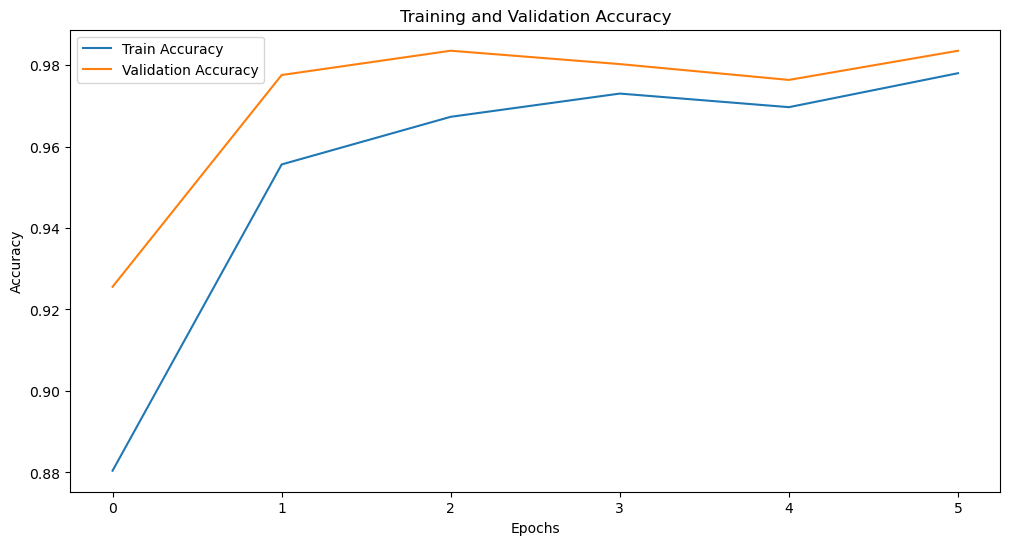

In [32]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



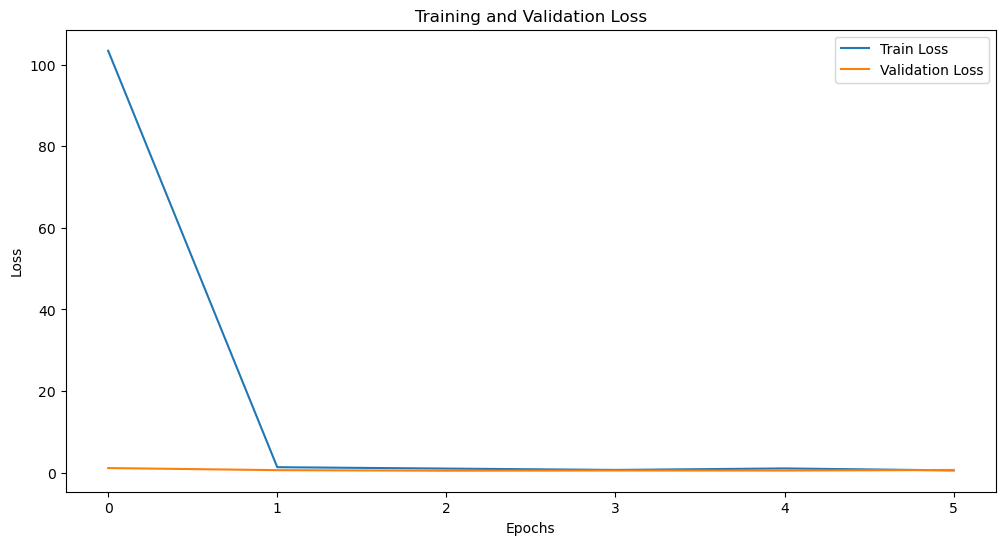

In [33]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [35]:
# Load the best model
print("Loading the best model")
model.load_weights('best_model.keras')

# Evaluate the model
print("Evaluating the model")
y_pred_prob = model.predict([X_test, X_test_cnn_lstm, X_test_cnn_lstm])
y_pred = (y_pred_prob > 0.5).astype(int)


Loading the best model
Evaluating the model
47626/47626 ━━━━━━━━━━━━━━━━━━━━ 201s 4ms/step


In [39]:
# Calculate confusion matrix and classification report
print("Generating classification report")
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Classification Report:")
print(cr)

Generating classification report
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1331339
           1       0.89      1.00      0.94    192690

    accuracy                           0.98   1524029
   macro avg       0.94      0.99      0.96   1524029
weighted avg       0.99      0.98      0.98   1524029



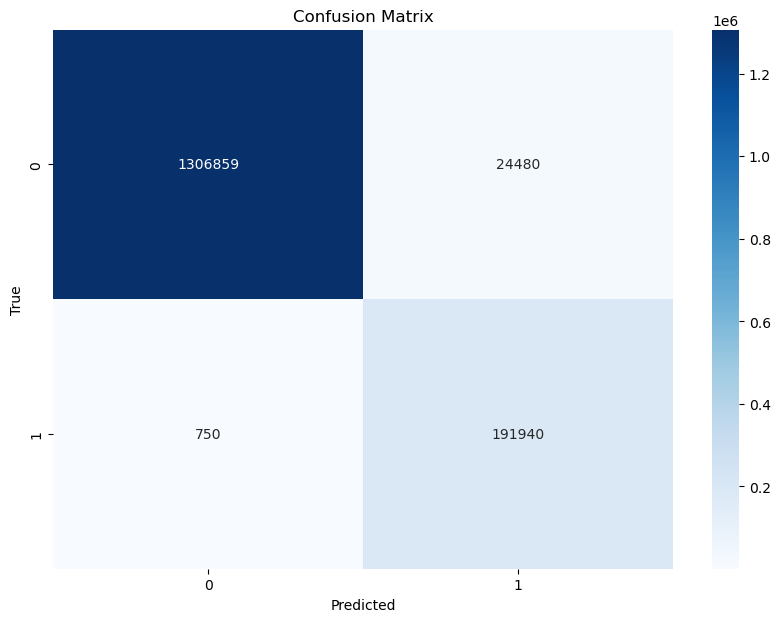

In [37]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



Generating ROC curve


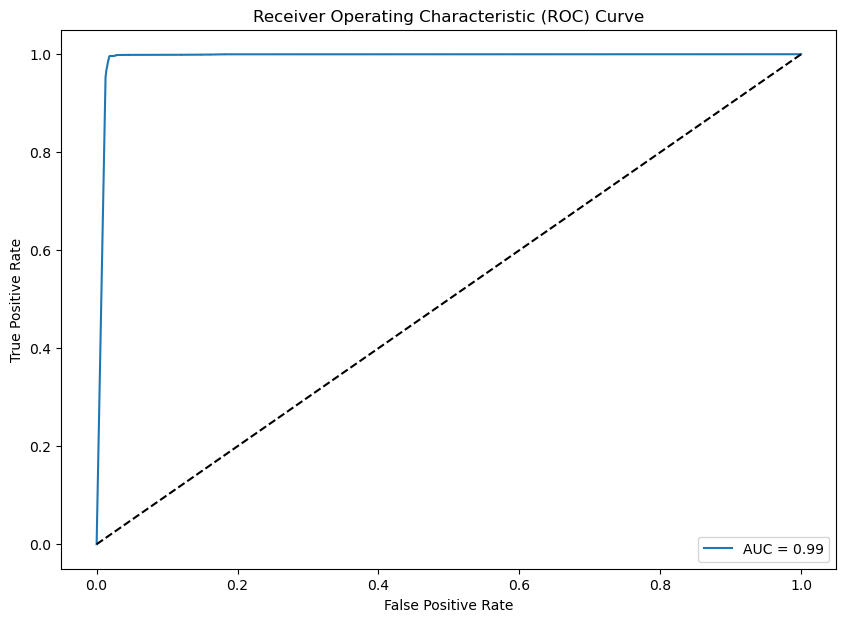

In [40]:
# ROC curve and AUC
print("Generating ROC curve")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



Generating Precision-Recall curve


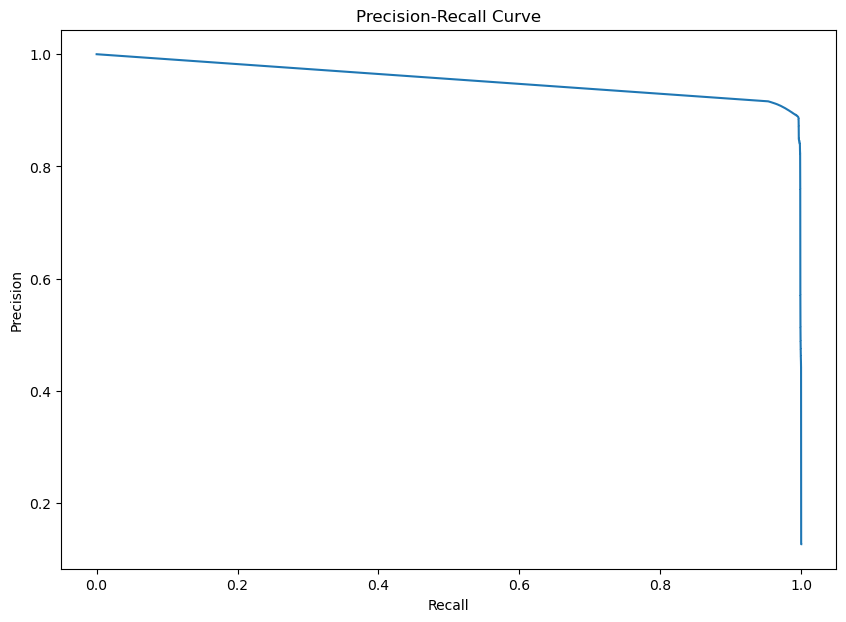

In [41]:
# Precision-Recall curve
print("Generating Precision-Recall curve")
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
